In [1]:
import torch
import torch.nn as nn
from datasets import load_dataset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import collections
from dataclasses import dataclass
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import random
from sklearn.metrics import accuracy_score, precision_score
import gc
import joblib
import optuna

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Проверка activation-функций

In [3]:
class Activations(nn.Module):
    actfs = {
        'relu': {
            'my': lambda x: (torch.abs(x) + x) / 2, 
            'torch':  nn.ReLU()},
        'gelu': {
            'my': lambda x: x * 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2)))), 
            'torch':  nn.GELU()},
        # параметр b = 1
        'swish': {
            'my': lambda x: x*(1/(1+torch.exp(-x))), 
            'torch':  nn.SiLU()},
        # параметр beta = 1
        'softplus': {
            'my': lambda x: torch.log(1 + torch.exp(x)), 
            'torch':  nn.Softplus()},
        'custom': {
            'my': lambda x: x}
    }

    _parameters = {}
    _modules = {}
    _buffers = {}
    _state_dict_pre_hooks = {}
    _state_dict_hooks = {}
    _load_state_dict_pre_hooks = {}
    _load_state_dict_post_hooks = {}

    def __init__(self, actf_name, impl_author) -> None:
        self.selected_act = actf_name
        self.impl = impl_author

    def __call__(self, x):
        return self.actfs[self.selected_act][self.impl](x)

In [4]:
def draw_factivations(impl_author, actf_names):
    x = torch.arange(-10,10,0.5)
    plt.figure(figsize=(4,3))
    for actf in actf_names:
        act = Activations(actf, impl_author)
        y = act(x)
        plt.plot(x, y, label=actf)
    plt.legend()
    plt.title(f"{impl_author} activation-functions")
    plt.grid()
    plt.show()

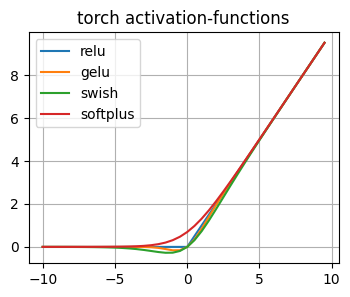

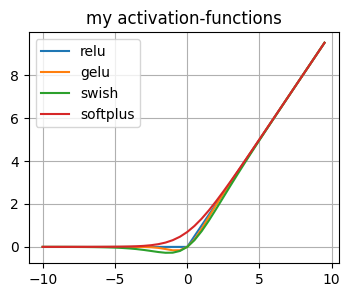

In [5]:
draw_factivations('torch', ['relu','gelu', 'swish', 'softplus'])
draw_factivations('my', ['relu','gelu', 'swish', 'softplus'])

### Реализация простой свёрточной нейронной сети

In [6]:
class ActFuncTestNN(nn.Module):
    def __init__(self, activation_f) -> None:
        super(ActFuncTestNN, self).__init__()
        
        self.conv_block = nn.Sequential(
            # bx1x28x28
            nn.Conv2d(in_channels=1, out_channels=4, 
                      kernel_size=2, stride=2, ),
            activation_f,
            # bx4x14x14
            nn.MaxPool2d(kernel_size=2, stride=2)
            # bx4x7x7
        )

        self.linear_block = nn.Sequential(
            nn.Flatten(),
            # bx196
            nn.Linear(in_features=196, out_features=32),
            activation_f,
            # bx32
            nn.Linear(in_features=32, out_features=10)
            # bx10
        )
        

    def forward(self, x):
        x = self.conv_block(x)
        x = self.linear_block(x)
        return x
    
def param_count(model):
    return sum([p.numel() for p in model.parameters()])

### Подготовка тренировочной/валидационной выборок

In [7]:
data = load_dataset('mnist')

In [8]:
print(len(data['train']),len(data['test']))

60000 10000


In [9]:
class CustomMNISTDataset(Dataset):
    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx):
        image = self._data[idx]['image']
        label = self._data[idx]['label']
        return image, label
    
    def __getitems__(self, idxs):
        return [self.__getitem__(idx) for idx in idxs]
        

def custom_collate(data):
    images = torch.cat([transforms.ToTensor()(item[0]).view(1,1,28,28) for item in data], 0)
    labels = torch.tensor([item[1] for item in data])

    return {
        "images": images, 
        "labels": labels
    }

In [10]:
# Datasets
train_dataset = CustomMNISTDataset(data['train'])
eval_dataset = CustomMNISTDataset(data['test'])

# Dataloader
train_dataloader = DataLoader(train_dataset, batch_size=32, 
                              shuffle=True, 
                              collate_fn=custom_collate)
eval_dataloader = DataLoader(eval_dataset, batch_size=32,
                              collate_fn=custom_collate)

### Подготовка функций обучения

In [11]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    losses = []
    process = tqdm(loader)
    for batch in process:
        optimizer.zero_grad()

        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(batch['images'])
        loss = criterion(output, batch['labels'])

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        process.set_postfix({"avg_loss": np.mean(losses)})

    return losses

def evaluate(model, loader, criterion, device):
    model.eval()
    losses = []
    predicted_labels = []
    target_labels = []

    process = tqdm(loader)
    for batch in process:

        batch = {k: v.to(device) for k, v in batch.items()}

        output = model(batch['images'])
        loss = criterion(output, batch['labels'])
        predicted = torch.argmax(output, dim=-1)

        losses.append(loss.item())
        process.set_postfix({"avg_loss": np.mean(losses)})

        #
        predicted_labels += predicted.cpu()
        target_labels += batch['labels'].cpu()
    
    acc_score = accuracy_score(target_labels, predicted_labels)
    prec_score = precision_score(target_labels, predicted_labels, average='micro')

    return losses, {'accuracy': acc_score, 'precision': prec_score}

def run(epochs, actf_name, act_cls, train_loader, eval_loader, device, to_save=True):

    model = ActFuncTestNN(act_cls).to(device)
    #print("model parameters count: ",param_count(model))

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    ml_train = []
    ml_eval = []
    eval_scores = []
    best_score = 0

    for i in range(epochs):
        train_losses = train(model, train_loader, 
                             optimizer, criterion, device)
        eval_losses, eval_metrics = evaluate(model, eval_loader, 
                                            criterion, device)
        
        torch.cuda.empty_cache()
        gc.collect()

        if best_score < eval_metrics['accuracy']:
            #print("Update Best Model")
            if to_save:
                torch.save(model.state_dict(), f"{actf_name}_bestmodel.pt")
            best_score = eval_metrics['accuracy']

        ml_train.append(np.mean(train_losses))
        ml_eval.append(np.mean(eval_losses))
        eval_scores.append(eval_metrics)

        #print(f"Epoch {i+1}: tain_loss - {round(ml_train[-1], 5)} | eval_loss - {round(ml_eval[-1],5)}")
        print(eval_scores[-1])


    return model, ml_train, ml_eval, best_score, eval_scores


### Обучение модели с базовыми функциями активации

In [12]:
def experiment(actf_pool):
    scores = []
    for act_name in actf_pool:
        print(f"Start {act_name}-model training...")
        print("==========")
        act_cls = Activations(act_name, 'my')
        _, _, _, _, score_eval = run(5, act_name, act_cls, train_dataloader, eval_dataloader, 'cuda')
        print("Done!\n")
        scores.append(score_eval)
    return scores

def draw_actf_scores(actf_pool,scores):
    plt.figure(figsize=(5,4))
    for atn_name, score in zip(actf_pool, scores):
        plt.plot(list(range(1,len(score)+1)), list([item['accuracy'] for item in score]), 
                 label=atn_name)
    plt.legend()
    plt.xlabel("эпоха")
    plt.ylabel("accuracy")
    plt.grid()
    plt.show()

In [13]:
defact_names = ['relu', 'gelu', 'swish', 'softplus']
defact_scores = experiment(defact_names)

Start relu-model training...


100%|██████████| 313/313 [00:03<00:00, 85.15it/s, avg_loss=0.246]


{'accuracy': 0.9196, 'precision': 0.9196}


100%|██████████| 313/313 [00:03<00:00, 90.51it/s, avg_loss=0.205]


{'accuracy': 0.936, 'precision': 0.936}


100%|██████████| 313/313 [00:03<00:00, 92.44it/s, avg_loss=0.204]


{'accuracy': 0.9373, 'precision': 0.9373}


100%|██████████| 313/313 [00:03<00:00, 91.92it/s, avg_loss=0.215]


{'accuracy': 0.9321, 'precision': 0.9321}


100%|██████████| 313/313 [00:03<00:00, 89.86it/s, avg_loss=0.178]


{'accuracy': 0.9445, 'precision': 0.9445}
Done!

Start gelu-model training...


100%|██████████| 313/313 [00:03<00:00, 91.17it/s, avg_loss=0.244]


{'accuracy': 0.9221, 'precision': 0.9221}


100%|██████████| 313/313 [00:03<00:00, 90.03it/s, avg_loss=0.175]


{'accuracy': 0.9445, 'precision': 0.9445}


100%|██████████| 313/313 [00:03<00:00, 90.32it/s, avg_loss=0.155]


{'accuracy': 0.9516, 'precision': 0.9516}


100%|██████████| 313/313 [00:03<00:00, 91.53it/s, avg_loss=0.174]


{'accuracy': 0.9462, 'precision': 0.9462}


100%|██████████| 313/313 [00:03<00:00, 91.79it/s, avg_loss=0.143]


{'accuracy': 0.9526, 'precision': 0.9526}
Done!

Start swish-model training...


100%|██████████| 313/313 [00:03<00:00, 91.51it/s, avg_loss=0.219]


{'accuracy': 0.9309, 'precision': 0.9309}


100%|██████████| 313/313 [00:03<00:00, 90.84it/s, avg_loss=0.155]


{'accuracy': 0.9483, 'precision': 0.9483}


100%|██████████| 313/313 [00:03<00:00, 91.85it/s, avg_loss=0.138]


{'accuracy': 0.955, 'precision': 0.955}


100%|██████████| 313/313 [00:03<00:00, 91.37it/s, avg_loss=0.142]


{'accuracy': 0.9534, 'precision': 0.9534}


100%|██████████| 313/313 [00:03<00:00, 91.46it/s, avg_loss=0.126]


{'accuracy': 0.9591, 'precision': 0.9591}
Done!

Start softplus-model training...


100%|██████████| 313/313 [00:03<00:00, 92.75it/s, avg_loss=0.425]


{'accuracy': 0.87, 'precision': 0.87}


100%|██████████| 313/313 [00:03<00:00, 91.97it/s, avg_loss=0.369]


{'accuracy': 0.8862, 'precision': 0.8862}


100%|██████████| 313/313 [00:03<00:00, 92.19it/s, avg_loss=0.284]


{'accuracy': 0.9092, 'precision': 0.9092}


100%|██████████| 313/313 [00:03<00:00, 93.34it/s, avg_loss=0.265]


{'accuracy': 0.9169, 'precision': 0.9169}


100%|██████████| 313/313 [00:03<00:00, 92.89it/s, avg_loss=0.234]


{'accuracy': 0.928, 'precision': 0.928}
Done!



In [18]:
defact_scores

[[{'accuracy': 0.9196, 'precision': 0.9196},
  {'accuracy': 0.936, 'precision': 0.936},
  {'accuracy': 0.9373, 'precision': 0.9373},
  {'accuracy': 0.9321, 'precision': 0.9321},
  {'accuracy': 0.9445, 'precision': 0.9445}],
 [{'accuracy': 0.9221, 'precision': 0.9221},
  {'accuracy': 0.9445, 'precision': 0.9445},
  {'accuracy': 0.9516, 'precision': 0.9516},
  {'accuracy': 0.9462, 'precision': 0.9462},
  {'accuracy': 0.9526, 'precision': 0.9526}],
 [{'accuracy': 0.9309, 'precision': 0.9309},
  {'accuracy': 0.9483, 'precision': 0.9483},
  {'accuracy': 0.955, 'precision': 0.955},
  {'accuracy': 0.9534, 'precision': 0.9534},
  {'accuracy': 0.9591, 'precision': 0.9591}],
 [{'accuracy': 0.87, 'precision': 0.87},
  {'accuracy': 0.8862, 'precision': 0.8862},
  {'accuracy': 0.9092, 'precision': 0.9092},
  {'accuracy': 0.9169, 'precision': 0.9169},
  {'accuracy': 0.928, 'precision': 0.928}]]

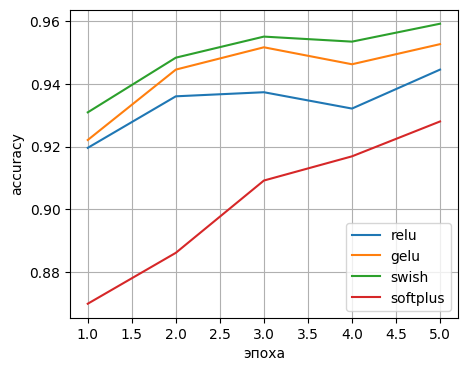

In [14]:
draw_actf_scores(defact_names, defact_scores)

### Эксперименты с кастомной функцией

In [19]:
def objective(trials):
    # Настраиваем гиперпарметры у кастомной функции
    a = trials.suggest_float('a',0.5, 100, log=True)
    b = trials.suggest_float('b',0.5, 100, log=True)
    c = trials.suggest_float('c',0.000001, 2, log=True)
    custom_func = lambda x: x*(a/(b + torch.exp(-x*c)))

    act_cls = Activations('custom', 'my')
    act_cls.actfs['custom']['my'] = custom_func
    _, _, _, best_score, _ = run(1, 'custom', act_cls, 
                                 train_dataloader, eval_dataloader, 
                                 'cuda', to_save=False)

    return best_score

In [20]:
OPTUNA_TRIALS = 100
study = optuna.create_study(directions=['maximize'])
study.optimize(objective, n_trials=OPTUNA_TRIALS, show_progress_bar=True)

joblib.dump(study, f"./custom_optuna_study.pkl")

[I 2024-03-21 09:27:33,048] A new study created in memory with name: no-name-b224cc11-f6a3-4917-b886-378c6acc75f8


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:03<00:00, 82.97it/s, avg_loss=0.303]


{'accuracy': 0.9061, 'precision': 0.9061}
[I 2024-03-21 09:28:02,368] Trial 0 finished with value: 0.9061 and parameters: {'a': 9.053574678771659, 'b': 4.763311548450881, 'c': 0.0007481472068231906}. Best is trial 0 with value: 0.9061.


100%|██████████| 313/313 [00:03<00:00, 83.72it/s, avg_loss=0.352]


{'accuracy': 0.8914, 'precision': 0.8914}
[I 2024-03-21 09:28:31,187] Trial 1 finished with value: 0.8914 and parameters: {'a': 60.04966410979884, 'b': 7.782277191093398, 'c': 0.0002219661560061277}. Best is trial 0 with value: 0.9061.


100%|██████████| 313/313 [00:03<00:00, 83.23it/s, avg_loss=0.277]


{'accuracy': 0.9171, 'precision': 0.9171}
[I 2024-03-21 09:28:59,930] Trial 2 finished with value: 0.9171 and parameters: {'a': 4.996016979000786, 'b': 55.433745543372595, 'c': 4.613087086155052e-05}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 80.09it/s, avg_loss=0.306]


{'accuracy': 0.9038, 'precision': 0.9038}
[I 2024-03-21 09:29:30,231] Trial 3 finished with value: 0.9038 and parameters: {'a': 0.7958994669072008, 'b': 11.496566106700586, 'c': 0.6675901712908141}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 81.56it/s, avg_loss=0.372]


{'accuracy': 0.887, 'precision': 0.887}
[I 2024-03-21 09:30:00,295] Trial 4 finished with value: 0.887 and parameters: {'a': 2.1338564079983247, 'b': 26.186714222091698, 'c': 0.011157958838511046}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 82.38it/s, avg_loss=0.282]


{'accuracy': 0.9113, 'precision': 0.9113}
[I 2024-03-21 09:30:29,565] Trial 5 finished with value: 0.9113 and parameters: {'a': 54.726362695706804, 'b': 80.24511429611661, 'c': 0.00018533697649690008}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 82.16it/s, avg_loss=0.288]


{'accuracy': 0.9123, 'precision': 0.9123}
[I 2024-03-21 09:30:58,913] Trial 6 finished with value: 0.9123 and parameters: {'a': 14.931870025371495, 'b': 3.5927147682365406, 'c': 3.961137583769389e-05}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 82.01it/s, avg_loss=1.04]


{'accuracy': 0.654, 'precision': 0.654}
[I 2024-03-21 09:31:28,226] Trial 7 finished with value: 0.654 and parameters: {'a': 1.7695230058972302, 'b': 60.327712057184016, 'c': 7.74188447875075e-06}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 80.26it/s, avg_loss=0.291]


{'accuracy': 0.9103, 'precision': 0.9103}
[I 2024-03-21 09:31:57,858] Trial 8 finished with value: 0.9103 and parameters: {'a': 0.5024816529764491, 'b': 0.9257833987183732, 'c': 9.27797482687738e-06}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 80.71it/s, avg_loss=0.296]


{'accuracy': 0.9101, 'precision': 0.9101}
[I 2024-03-21 09:32:27,315] Trial 9 finished with value: 0.9101 and parameters: {'a': 1.181220902013493, 'b': 2.2993406589906833, 'c': 0.0018769134460281602}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 81.23it/s, avg_loss=0.355]


{'accuracy': 0.8896, 'precision': 0.8896}
[I 2024-03-21 09:32:56,790] Trial 10 finished with value: 0.8896 and parameters: {'a': 3.9424755877422877, 'b': 28.830530318412745, 'c': 1.4081190633181072e-06}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 82.77it/s, avg_loss=0.289]


{'accuracy': 0.9085, 'precision': 0.9085}
[I 2024-03-21 09:33:26,184] Trial 11 finished with value: 0.9085 and parameters: {'a': 9.148906495300539, 'b': 3.10755242750164, 'c': 5.300027944398611e-05}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 81.47it/s, avg_loss=0.287]


{'accuracy': 0.9117, 'precision': 0.9117}
[I 2024-03-21 09:33:55,660] Trial 12 finished with value: 0.9117 and parameters: {'a': 17.858246365495408, 'b': 13.391687818258069, 'c': 1.9000958026405905e-05}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 81.05it/s, avg_loss=0.3]


{'accuracy': 0.9067, 'precision': 0.9067}
[I 2024-03-21 09:34:25,117] Trial 13 finished with value: 0.9067 and parameters: {'a': 21.2047716334333, 'b': 1.323367791150739, 'c': 1.8644574169411245e-06}. Best is trial 2 with value: 0.9171.


100%|██████████| 313/313 [00:03<00:00, 78.95it/s, avg_loss=0.254]


{'accuracy': 0.9207, 'precision': 0.9207}
[I 2024-03-21 09:34:55,427] Trial 14 finished with value: 0.9207 and parameters: {'a': 4.3370250932391565, 'b': 0.6147781846562279, 'c': 2.810979643373062e-05}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 81.03it/s, avg_loss=0.325]


{'accuracy': 0.9074, 'precision': 0.9074}
[I 2024-03-21 09:35:25,314] Trial 15 finished with value: 0.9074 and parameters: {'a': 4.001870333186267, 'b': 0.6858416760685738, 'c': 9.122760064750512e-05}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:04<00:00, 77.50it/s, avg_loss=0.297]


{'accuracy': 0.9038, 'precision': 0.9038}
[I 2024-03-21 09:35:55,026] Trial 16 finished with value: 0.9038 and parameters: {'a': 4.542899394514343, 'b': 1.884174598216523, 'c': 3.958005650858723e-06}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.55it/s, avg_loss=0.272]


{'accuracy': 0.9155, 'precision': 0.9155}
[I 2024-03-21 09:36:24,458] Trial 17 finished with value: 0.9155 and parameters: {'a': 2.556198906875901, 'b': 0.5650890011234332, 'c': 7.095953961640753e-06}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 81.62it/s, avg_loss=0.296]


{'accuracy': 0.9096, 'precision': 0.9096}
[I 2024-03-21 09:36:53,857] Trial 18 finished with value: 0.9096 and parameters: {'a': 6.173527093717129, 'b': 1.2958315057385412, 'c': 2.9842843127451366e-05}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.49it/s, avg_loss=0.268]


{'accuracy': 0.9152, 'precision': 0.9152}
[I 2024-03-21 09:37:23,268] Trial 19 finished with value: 0.9152 and parameters: {'a': 2.6241272028215223, 'b': 4.974233828212002, 'c': 1.1252446305300075e-06}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.39it/s, avg_loss=0.406]


{'accuracy': 0.8756, 'precision': 0.8756}
[I 2024-03-21 09:37:52,261] Trial 20 finished with value: 0.8756 and parameters: {'a': 1.5112360583866629, 'b': 93.55631222703447, 'c': 0.00038716106698747033}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.21it/s, avg_loss=0.346]


{'accuracy': 0.8937, 'precision': 0.8937}
[I 2024-03-21 09:38:21,495] Trial 21 finished with value: 0.8937 and parameters: {'a': 2.718811315174658, 'b': 0.6293987405589307, 'c': 1.566664192262679e-05}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.34it/s, avg_loss=0.294]


{'accuracy': 0.9085, 'precision': 0.9085}
[I 2024-03-21 09:38:50,751] Trial 22 finished with value: 0.9085 and parameters: {'a': 3.383640500312059, 'b': 0.5385236789167388, 'c': 5.756291106552028e-06}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.25it/s, avg_loss=0.321]


{'accuracy': 0.8985, 'precision': 0.8985}
[I 2024-03-21 09:39:19,852] Trial 23 finished with value: 0.8985 and parameters: {'a': 2.5856322979796853, 'b': 0.5001910408839981, 'c': 6.506680644409682e-05}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 84.08it/s, avg_loss=0.378]


{'accuracy': 0.8792, 'precision': 0.8792}
[I 2024-03-21 09:39:48,972] Trial 24 finished with value: 0.8792 and parameters: {'a': 6.09180427496955, 'b': 0.8592726114850305, 'c': 4.306667523519485e-06}. Best is trial 14 with value: 0.9207.


100%|██████████| 313/313 [00:03<00:00, 83.13it/s, avg_loss=0.226]


{'accuracy': 0.926, 'precision': 0.926}
[I 2024-03-21 09:40:18,002] Trial 25 finished with value: 0.926 and parameters: {'a': 1.1996557730011934, 'b': 1.1899654983714032, 'c': 1.6326587337007567e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.65it/s, avg_loss=0.302]


{'accuracy': 0.9088, 'precision': 0.9088}
[I 2024-03-21 09:40:47,234] Trial 26 finished with value: 0.9088 and parameters: {'a': 1.1404046568871702, 'b': 1.6053262298797424, 'c': 0.00010980313966188378}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.07it/s, avg_loss=0.292]


{'accuracy': 0.9055, 'precision': 0.9055}
[I 2024-03-21 09:41:16,297] Trial 27 finished with value: 0.9055 and parameters: {'a': 1.3490766758327848, 'b': 1.0915632866820792, 'c': 1.9368022112837e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.48it/s, avg_loss=0.262]


{'accuracy': 0.9158, 'precision': 0.9158}
[I 2024-03-21 09:41:45,392] Trial 28 finished with value: 0.9158 and parameters: {'a': 1.957942108193481, 'b': 2.083752795719481, 'c': 3.888641663844878e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.58it/s, avg_loss=0.33]


{'accuracy': 0.8987, 'precision': 0.8987}
[I 2024-03-21 09:42:14,477] Trial 29 finished with value: 0.8987 and parameters: {'a': 0.837544517402377, 'b': 0.9582067979650924, 'c': 0.0006014642047781334}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.21it/s, avg_loss=0.304]


{'accuracy': 0.9029, 'precision': 0.9029}
[I 2024-03-21 09:42:43,749] Trial 30 finished with value: 0.9029 and parameters: {'a': 9.486491661464344, 'b': 1.3398763441352048, 'c': 0.0020821363487737807}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 81.55it/s, avg_loss=0.244]


{'accuracy': 0.9225, 'precision': 0.9225}
[I 2024-03-21 09:43:12,995] Trial 31 finished with value: 0.9225 and parameters: {'a': 1.9078903310696829, 'b': 2.1965820927675135, 'c': 3.5692615250624634e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.66it/s, avg_loss=0.3]


{'accuracy': 0.9055, 'precision': 0.9055}
[I 2024-03-21 09:43:42,316] Trial 32 finished with value: 0.9055 and parameters: {'a': 5.792838173615806, 'b': 2.3767712630765936, 'c': 0.00015397888490243625}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.01it/s, avg_loss=0.3]


{'accuracy': 0.9065, 'precision': 0.9065}
[I 2024-03-21 09:44:11,595] Trial 33 finished with value: 0.9065 and parameters: {'a': 1.825401502620818, 'b': 0.7884627544674935, 'c': 1.7827637805127686e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.22it/s, avg_loss=0.28]


{'accuracy': 0.9091, 'precision': 0.9091}
[I 2024-03-21 09:44:40,916] Trial 34 finished with value: 0.9091 and parameters: {'a': 3.516310126218685, 'b': 6.876460013172689, 'c': 0.00028461148849864035}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.30it/s, avg_loss=0.25]


{'accuracy': 0.9224, 'precision': 0.9224}
[I 2024-03-21 09:45:09,977] Trial 35 finished with value: 0.9224 and parameters: {'a': 0.9997866554273604, 'b': 3.05594344117703, 'c': 9.891372675155712e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.38it/s, avg_loss=0.264]


{'accuracy': 0.9177, 'precision': 0.9177}
[I 2024-03-21 09:45:39,069] Trial 36 finished with value: 0.9177 and parameters: {'a': 0.9065697917585303, 'b': 1.749538961445256, 'c': 0.000100430394288249}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.02it/s, avg_loss=0.325]


{'accuracy': 0.9017, 'precision': 0.9017}
[I 2024-03-21 09:46:08,164] Trial 37 finished with value: 0.9017 and parameters: {'a': 0.6679852901723605, 'b': 2.7693605321976213, 'c': 0.00022251941421763975}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.38it/s, avg_loss=0.304]


{'accuracy': 0.9047, 'precision': 0.9047}
[I 2024-03-21 09:46:37,285] Trial 38 finished with value: 0.9047 and parameters: {'a': 1.0834953605192803, 'b': 3.965250352005897, 'c': 0.0008622376092389566}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.96it/s, avg_loss=0.309]


{'accuracy': 0.8999, 'precision': 0.8999}
[I 2024-03-21 09:47:06,398] Trial 39 finished with value: 0.8999 and parameters: {'a': 1.5168635201817702, 'b': 1.145607272937657, 'c': 3.877745428243955e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.98it/s, avg_loss=0.31]


{'accuracy': 0.9057, 'precision': 0.9057}
[I 2024-03-21 09:47:35,717] Trial 40 finished with value: 0.9057 and parameters: {'a': 0.6606120718821161, 'b': 0.7819076346844565, 'c': 1.2475929220560486e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.16it/s, avg_loss=0.249]


{'accuracy': 0.9258, 'precision': 0.9258}
[I 2024-03-21 09:48:04,880] Trial 41 finished with value: 0.9258 and parameters: {'a': 0.9612703338876775, 'b': 1.6925606379841702, 'c': 9.227858780995274e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.07it/s, avg_loss=0.329]


{'accuracy': 0.8992, 'precision': 0.8992}
[I 2024-03-21 09:48:33,902] Trial 42 finished with value: 0.8992 and parameters: {'a': 0.9738986079769232, 'b': 1.5401053084823941, 'c': 7.682804643578128e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.18it/s, avg_loss=0.295]


{'accuracy': 0.9081, 'precision': 0.9081}
[I 2024-03-21 09:49:03,050] Trial 43 finished with value: 0.9081 and parameters: {'a': 1.2746305798166278, 'b': 2.740223969249592, 'c': 2.980779301754692e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.29it/s, avg_loss=0.277]


{'accuracy': 0.9129, 'precision': 0.9129}
[I 2024-03-21 09:49:32,141] Trial 44 finished with value: 0.9129 and parameters: {'a': 1.5498676227045676, 'b': 2.034917273180853, 'c': 0.00018149524989488405}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.43it/s, avg_loss=0.31]


{'accuracy': 0.908, 'precision': 0.908}
[I 2024-03-21 09:50:01,244] Trial 45 finished with value: 0.908 and parameters: {'a': 0.7316745347090808, 'b': 1.025381340125509, 'c': 2.9257639795569944e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.10it/s, avg_loss=0.259]


{'accuracy': 0.9212, 'precision': 0.9212}
[I 2024-03-21 09:50:30,391] Trial 46 finished with value: 0.9212 and parameters: {'a': 0.5299667494075735, 'b': 1.5645456031409335, 'c': 1.0454172647871194e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.43it/s, avg_loss=0.351]


{'accuracy': 0.8933, 'precision': 0.8933}
[I 2024-03-21 09:50:59,545] Trial 47 finished with value: 0.8933 and parameters: {'a': 0.5624560061797697, 'b': 3.4659171659537775, 'c': 9.165924277916074e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.23it/s, avg_loss=0.354]


{'accuracy': 0.8948, 'precision': 0.8948}
[I 2024-03-21 09:51:28,672] Trial 48 finished with value: 0.8948 and parameters: {'a': 0.5365269177510366, 'b': 2.6275995790363607, 'c': 1.0744679371564755e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.80it/s, avg_loss=0.323]


{'accuracy': 0.9012, 'precision': 0.9012}
[I 2024-03-21 09:51:57,660] Trial 49 finished with value: 0.9012 and parameters: {'a': 0.8631622561445554, 'b': 1.5855546253775548, 'c': 2.325147113735536e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.09it/s, avg_loss=0.322]


{'accuracy': 0.9035, 'precision': 0.9035}
[I 2024-03-21 09:52:26,828] Trial 50 finished with value: 0.9035 and parameters: {'a': 0.5043942413128529, 'b': 2.0809220275197404, 'c': 6.006048801620824e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.06it/s, avg_loss=0.287]


{'accuracy': 0.9146, 'precision': 0.9146}
[I 2024-03-21 09:52:56,096] Trial 51 finished with value: 0.9146 and parameters: {'a': 1.0118074242165143, 'b': 0.7045983347710891, 'c': 2.8857491865720013e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.91it/s, avg_loss=0.254]


{'accuracy': 0.9202, 'precision': 0.9202}
[I 2024-03-21 09:53:25,166] Trial 52 finished with value: 0.9202 and parameters: {'a': 0.6944745725332582, 'b': 1.2220039672713712, 'c': 7.782924274751271e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 83.32it/s, avg_loss=0.268]


{'accuracy': 0.9199, 'precision': 0.9199}
[I 2024-03-21 09:53:54,277] Trial 53 finished with value: 0.9199 and parameters: {'a': 1.2011489825363915, 'b': 0.9473257336940885, 'c': 4.33961415073146e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.34it/s, avg_loss=0.318]


{'accuracy': 0.9032, 'precision': 0.9032}
[I 2024-03-21 09:54:23,852] Trial 54 finished with value: 0.9032 and parameters: {'a': 2.1488305951409217, 'b': 1.5520317128514851, 'c': 5.035193464065679e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 81.18it/s, avg_loss=0.281]


{'accuracy': 0.9132, 'precision': 0.9132}
[I 2024-03-21 09:54:53,391] Trial 55 finished with value: 0.9132 and parameters: {'a': 1.696042461535233, 'b': 2.359645123744098, 'c': 1.9932374084230194e-05}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 82.62it/s, avg_loss=0.258]


{'accuracy': 0.9201, 'precision': 0.9201}
[I 2024-03-21 09:55:23,794] Trial 56 finished with value: 0.9201 and parameters: {'a': 0.8078895762428624, 'b': 1.3396540566121495, 'c': 0.0001243973315495849}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:04<00:00, 77.54it/s, avg_loss=0.269]


{'accuracy': 0.9198, 'precision': 0.9198}
[I 2024-03-21 09:55:54,870] Trial 57 finished with value: 0.9198 and parameters: {'a': 1.3933592833451418, 'b': 1.8859719850466938, 'c': 5.9346086898662085e-06}. Best is trial 25 with value: 0.926.


100%|██████████| 313/313 [00:03<00:00, 78.70it/s, avg_loss=0.23]


{'accuracy': 0.9325, 'precision': 0.9325}
[I 2024-03-21 09:56:25,655] Trial 58 finished with value: 0.9325 and parameters: {'a': 1.0474330520213826, 'b': 3.2029187228142457, 'c': 1.639702877287446e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 77.82it/s, avg_loss=0.308]


{'accuracy': 0.9026, 'precision': 0.9026}
[I 2024-03-21 09:56:56,632] Trial 59 finished with value: 0.9026 and parameters: {'a': 1.0096202232375966, 'b': 3.192923890483454, 'c': 1.569079651220254e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.94it/s, avg_loss=0.366]


{'accuracy': 0.8902, 'precision': 0.8902}
[I 2024-03-21 09:57:27,724] Trial 60 finished with value: 0.8902 and parameters: {'a': 0.6365216431415118, 'b': 4.272988478399699, 'c': 2.0130939686810263e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.22it/s, avg_loss=0.245]


{'accuracy': 0.9233, 'precision': 0.9233}
[I 2024-03-21 09:57:58,584] Trial 61 finished with value: 0.9233 and parameters: {'a': 1.2400925995451983, 'b': 0.6289997836316158, 'c': 3.5789203370656892e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.78it/s, avg_loss=0.355]


{'accuracy': 0.8932, 'precision': 0.8932}
[I 2024-03-21 09:58:29,361] Trial 62 finished with value: 0.8932 and parameters: {'a': 0.8098429953186228, 'b': 3.113489173181888, 'c': 1.3134108074541339e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.29it/s, avg_loss=0.255]


{'accuracy': 0.918, 'precision': 0.918}
[I 2024-03-21 09:59:00,299] Trial 63 finished with value: 0.918 and parameters: {'a': 1.1973665114055325, 'b': 1.0936318612129836, 'c': 1.096343826981007e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.45it/s, avg_loss=0.29]


{'accuracy': 0.9099, 'precision': 0.9099}
[I 2024-03-21 09:59:31,083] Trial 64 finished with value: 0.9099 and parameters: {'a': 0.9991606219623069, 'b': 5.174892359996764, 'c': 1.089553093342934e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 78.03it/s, avg_loss=0.289]


{'accuracy': 0.9086, 'precision': 0.9086}
[I 2024-03-21 10:00:01,955] Trial 65 finished with value: 0.9086 and parameters: {'a': 1.3368462273236985, 'b': 2.2319903032845176, 'c': 3.4229686311410436e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 78.16it/s, avg_loss=0.266]


{'accuracy': 0.9163, 'precision': 0.9163}
[I 2024-03-21 10:00:32,902] Trial 66 finished with value: 0.9163 and parameters: {'a': 2.0936066540292537, 'b': 1.7987031707206107, 'c': 2.7871689286539384e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 78.22it/s, avg_loss=0.323]


{'accuracy': 0.9045, 'precision': 0.9045}
[I 2024-03-21 10:01:03,716] Trial 67 finished with value: 0.9045 and parameters: {'a': 0.6164604480334787, 'b': 1.4258701982402642, 'c': 1.8518964691121525e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.11it/s, avg_loss=0.295]


{'accuracy': 0.9093, 'precision': 0.9093}
[I 2024-03-21 10:01:34,045] Trial 68 finished with value: 0.9093 and parameters: {'a': 0.8041225953071929, 'b': 0.874015318150397, 'c': 5.130325556937162e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.67it/s, avg_loss=0.245]


{'accuracy': 0.9232, 'precision': 0.9232}
[I 2024-03-21 10:02:04,189] Trial 69 finished with value: 0.9232 and parameters: {'a': 1.6662396761302467, 'b': 0.6416492152015557, 'c': 8.332253177507402e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.73it/s, avg_loss=0.251]


{'accuracy': 0.9218, 'precision': 0.9218}
[I 2024-03-21 10:02:34,397] Trial 70 finished with value: 0.9218 and parameters: {'a': 1.5729851414568863, 'b': 0.6453206511179467, 'c': 6.018667526883486e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.35it/s, avg_loss=0.282]


{'accuracy': 0.9146, 'precision': 0.9146}
[I 2024-03-21 10:03:04,590] Trial 71 finished with value: 0.9146 and parameters: {'a': 1.6612387264154451, 'b': 0.6139177788875526, 'c': 6.803858251247927e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.01it/s, avg_loss=0.255]


{'accuracy': 0.9192, 'precision': 0.9192}
[I 2024-03-21 10:03:34,809] Trial 72 finished with value: 0.9192 and parameters: {'a': 1.4049464770877258, 'b': 0.7070274684384549, 'c': 4.006273615166602e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.29it/s, avg_loss=0.28]


{'accuracy': 0.9204, 'precision': 0.9204}
[I 2024-03-21 10:04:05,146] Trial 73 finished with value: 0.9204 and parameters: {'a': 1.933234080489511, 'b': 0.5183208355749152, 'c': 1.9344512048567267e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.24it/s, avg_loss=0.271]


{'accuracy': 0.9143, 'precision': 0.9143}
[I 2024-03-21 10:04:35,314] Trial 74 finished with value: 0.9143 and parameters: {'a': 1.1824467925119055, 'b': 0.5798707958254165, 'c': 4.3804005063856496e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.56it/s, avg_loss=0.302]


{'accuracy': 0.9058, 'precision': 0.9058}
[I 2024-03-21 10:05:05,460] Trial 75 finished with value: 0.9058 and parameters: {'a': 1.6650257588949993, 'b': 0.8187455910485112, 'c': 1.6000968674798556e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.12it/s, avg_loss=0.24]


{'accuracy': 0.9247, 'precision': 0.9247}
[I 2024-03-21 10:05:35,627] Trial 76 finished with value: 0.9247 and parameters: {'a': 0.9393301840627091, 'b': 0.7040178704511156, 'c': 1.0016793510300672e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.62it/s, avg_loss=0.278]


{'accuracy': 0.9109, 'precision': 0.9109}
[I 2024-03-21 10:06:05,988] Trial 77 finished with value: 0.9109 and parameters: {'a': 0.923077575836314, 'b': 0.9685570710458733, 'c': 2.4953714975712053e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.73it/s, avg_loss=0.323]


{'accuracy': 0.8961, 'precision': 0.8961}
[I 2024-03-21 10:06:36,191] Trial 78 finished with value: 0.8961 and parameters: {'a': 1.0574254127106157, 'b': 1.1402867951862163, 'c': 1.0783792533128528e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.25it/s, avg_loss=0.293]


{'accuracy': 0.9133, 'precision': 0.9133}
[I 2024-03-21 10:07:06,564] Trial 79 finished with value: 0.9133 and parameters: {'a': 0.7341079487068621, 'b': 0.7975916911892635, 'c': 1.5500391605839578e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 77.96it/s, avg_loss=0.289]


{'accuracy': 0.9099, 'precision': 0.9099}
[I 2024-03-21 10:07:37,625] Trial 80 finished with value: 0.9099 and parameters: {'a': 1.2893775231831892, 'b': 1.2625287792126052, 'c': 3.0286370508695865e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 77.63it/s, avg_loss=0.228]


{'accuracy': 0.9285, 'precision': 0.9285}
[I 2024-03-21 10:08:08,225] Trial 81 finished with value: 0.9285 and parameters: {'a': 1.4831956592070095, 'b': 0.6735917670981036, 'c': 5.88088248512393e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 77.45it/s, avg_loss=0.29]


{'accuracy': 0.9113, 'precision': 0.9113}
[I 2024-03-21 10:08:39,129] Trial 82 finished with value: 0.9113 and parameters: {'a': 1.059141662547686, 'b': 0.7153370742493607, 'c': 3.8529401735943875e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.93it/s, avg_loss=0.309]


{'accuracy': 0.8998, 'precision': 0.8998}
[I 2024-03-21 10:09:10,147] Trial 83 finished with value: 0.8998 and parameters: {'a': 0.9111771590077963, 'b': 0.5619184053471421, 'c': 7.560345575386694e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 78.32it/s, avg_loss=0.267]


{'accuracy': 0.9173, 'precision': 0.9173}
[I 2024-03-21 10:09:41,315] Trial 84 finished with value: 0.9173 and parameters: {'a': 2.2115368000783007, 'b': 0.5072991576871503, 'c': 1.1691119928571108e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.06it/s, avg_loss=0.265]


{'accuracy': 0.914, 'precision': 0.914}
[I 2024-03-21 10:10:12,131] Trial 85 finished with value: 0.914 and parameters: {'a': 1.4285940220254154, 'b': 0.9576192841794735, 'c': 7.502335147058736e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:04<00:00, 76.81it/s, avg_loss=0.289]


{'accuracy': 0.9092, 'precision': 0.9092}
[I 2024-03-21 10:10:43,193] Trial 86 finished with value: 0.9092 and parameters: {'a': 1.1426842338618728, 'b': 0.6633337593386673, 'c': 2.3199508317592468e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.03it/s, avg_loss=0.268]


{'accuracy': 0.9132, 'precision': 0.9132}
[I 2024-03-21 10:11:13,492] Trial 87 finished with value: 0.9132 and parameters: {'a': 2.4339287608983398, 'b': 0.7717625476755191, 'c': 1.3671130146152307e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.45it/s, avg_loss=0.254]


{'accuracy': 0.9234, 'precision': 0.9234}
[I 2024-03-21 10:11:43,780] Trial 88 finished with value: 0.9234 and parameters: {'a': 1.75371763504199, 'b': 0.8885769644276138, 'c': 2.081839772422834e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.81it/s, avg_loss=0.264]


{'accuracy': 0.9156, 'precision': 0.9156}
[I 2024-03-21 10:12:14,399] Trial 89 finished with value: 0.9156 and parameters: {'a': 1.8534933827136453, 'b': 1.0733230766197288, 'c': 1.9003024804555959e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.61it/s, avg_loss=0.27]


{'accuracy': 0.9124, 'precision': 0.9124}
[I 2024-03-21 10:12:44,240] Trial 90 finished with value: 0.9124 and parameters: {'a': 1.761354157967476, 'b': 0.594096050415776, 'c': 4.497942162414025e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 81.68it/s, avg_loss=0.288]


{'accuracy': 0.9056, 'precision': 0.9056}
[I 2024-03-21 10:13:13,844] Trial 91 finished with value: 0.9056 and parameters: {'a': 1.2724116260770397, 'b': 0.8987721611955256, 'c': 2.491821016989911e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.86it/s, avg_loss=0.258]


{'accuracy': 0.921, 'precision': 0.921}
[I 2024-03-21 10:13:43,657] Trial 92 finished with value: 0.921 and parameters: {'a': 1.501093558627951, 'b': 0.8571031877700837, 'c': 1.504981336630522e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 81.84it/s, avg_loss=0.26]


{'accuracy': 0.9201, 'precision': 0.9201}
[I 2024-03-21 10:14:13,289] Trial 93 finished with value: 0.9201 and parameters: {'a': 0.8960801235351602, 'b': 0.7363874879120498, 'c': 1.027273909761147e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 79.50it/s, avg_loss=0.258]


{'accuracy': 0.9206, 'precision': 0.9206}
[I 2024-03-21 10:14:43,197] Trial 94 finished with value: 0.9206 and parameters: {'a': 1.1218707997790087, 'b': 1.186799548505703, 'c': 8.170798933043742e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 81.22it/s, avg_loss=0.275]


{'accuracy': 0.9165, 'precision': 0.9165}
[I 2024-03-21 10:15:12,856] Trial 95 finished with value: 0.9165 and parameters: {'a': 2.908212061436298, 'b': 1.3922316093859746, 'c': 2.5687813628033003e-05}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.90it/s, avg_loss=0.25]


{'accuracy': 0.9235, 'precision': 0.9235}
[I 2024-03-21 10:15:42,880] Trial 96 finished with value: 0.9235 and parameters: {'a': 1.4666143808442953, 'b': 0.6451007884842528, 'c': 3.202759439564846e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 82.53it/s, avg_loss=0.292]


{'accuracy': 0.9148, 'precision': 0.9148}
[I 2024-03-21 10:16:12,583] Trial 97 finished with value: 0.9148 and parameters: {'a': 1.8892403649405196, 'b': 0.6605644950559886, 'c': 3.1228280063555287e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 80.51it/s, avg_loss=0.233]


{'accuracy': 0.9256, 'precision': 0.9256}
[I 2024-03-21 10:16:42,631] Trial 98 finished with value: 0.9256 and parameters: {'a': 1.4975182644605927, 'b': 1.041269571570695, 'c': 2.072128317162357e-06}. Best is trial 58 with value: 0.9325.


100%|██████████| 313/313 [00:03<00:00, 81.64it/s, avg_loss=0.273]


{'accuracy': 0.9137, 'precision': 0.9137}
[I 2024-03-21 10:17:12,559] Trial 99 finished with value: 0.9137 and parameters: {'a': 1.4402878679884672, 'b': 1.0266343334924946, 'c': 5.2242441636885684e-06}. Best is trial 58 with value: 0.9325.


['./custom_optuna_study.pkl']

### Лучшая кастомная функция

In [26]:
A,B,C = 2.5023733351402284, 1.1643264832383298, 0.6834049121496015
#A,B,C = 1.0474330520213826, 3.2029187228142457, 1.639702877287446e-06

custom_func = lambda x: x*(A/(B + torch.exp(-x*C)))
act_cls = Activations('custom', 'my')
act_cls.actfs['custom']['my'] = custom_func

_, _, _, best_score, eval_scores = run(5, 'custom', act_cls, train_dataloader, eval_dataloader, 'cuda', to_save=False)

100%|██████████| 313/313 [00:03<00:00, 90.03it/s, avg_loss=0.191]


{'accuracy': 0.939, 'precision': 0.939}


100%|██████████| 313/313 [00:03<00:00, 89.24it/s, avg_loss=0.173]


{'accuracy': 0.9483, 'precision': 0.9483}


100%|██████████| 313/313 [00:03<00:00, 90.41it/s, avg_loss=0.176]


{'accuracy': 0.9435, 'precision': 0.9435}


100%|██████████| 313/313 [00:03<00:00, 90.53it/s, avg_loss=0.176]


{'accuracy': 0.9461, 'precision': 0.9461}


100%|██████████| 313/313 [00:03<00:00, 89.98it/s, avg_loss=0.142]


{'accuracy': 0.9545, 'precision': 0.9545}


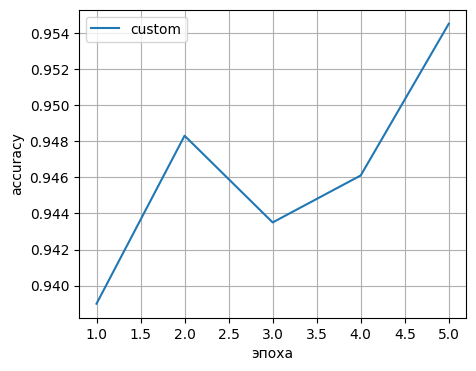

In [29]:
draw_actf_scores(['custom'],[eval_scores])

### Сравнение базовый функций активации с кастомной

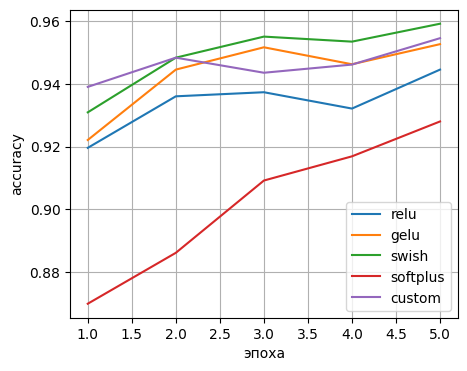

In [28]:
draw_actf_scores(defact_names + ['custom'], defact_scores + [eval_scores])